In [16]:
import pandas as pd

train_path = "train.csv"
test_path = "test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Formatted as FastText: __label__category text
train_data['formatted'] = "__label__" + train_data['category'] + " " + train_data['text']
test_data['formatted'] = "__label__" + test_data['category'] + " " + test_data['text']

print(train_data.head())
print(test_data.head())


                                                text      category  \
0                     I am still waiting on my card?  card_arrival   
1  What can I do if my card still hasn't arrived ...  card_arrival   
2  I have been waiting over a week. Is the card s...  card_arrival   
3  Can I track my card while it is in the process...  card_arrival   
4  How do I know if I will get my card, or if it ...  card_arrival   

                                           formatted  
0  __label__card_arrival I am still waiting on my...  
1  __label__card_arrival What can I do if my card...  
2  __label__card_arrival I have been waiting over...  
3  __label__card_arrival Can I track my card whil...  
4  __label__card_arrival How do I know if I will ...  
                                                text      category  \
0                           How do I locate my card?  card_arrival   
1  I still have not received my new card, I order...  card_arrival   
2  I ordered a card but it has not arri

In [17]:
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# Deactivated words list
stop_words = set(stopwords.words('english'))

# Text Cleaning Functions
def clean_text(text):
    text = text.lower()
    # Remove punctuation and extra spaces
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove Discontinued Words
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Cleaning of text for training and test sets
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Update FastText formatted columns
train_data['formatted'] = "__label__" + train_data['category'] + " " + train_data['cleaned_text']
test_data['formatted'] = "__label__" + test_data['category'] + " " + test_data['cleaned_text']

print(train_data.head())
print(test_data.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34745\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text      category  \
0                     I am still waiting on my card?  card_arrival   
1  What can I do if my card still hasn't arrived ...  card_arrival   
2  I have been waiting over a week. Is the card s...  card_arrival   
3  Can I track my card while it is in the process...  card_arrival   
4  How do I know if I will get my card, or if it ...  card_arrival   

                                           formatted  \
0           __label__card_arrival still waiting card   
1  __label__card_arrival card still hasnt arrived...   
2  __label__card_arrival waiting week card still ...   
3  __label__card_arrival track card process delivery   
4           __label__card_arrival know get card lost   

                       cleaned_text  
0                still waiting card  
1  card still hasnt arrived 2 weeks  
2    waiting week card still coming  
3       track card process delivery  
4                know get card lost  
              

In [18]:
from sklearn.utils import resample

# Distribution of access categories
category_counts = train_data['category'].value_counts()
print("Original category distribution:\n", category_counts)

# Finding thresholds for low-frequency categories
min_samples = 100  # Can be adjusted according to actual needs
low_freq_categories = category_counts[category_counts < min_samples].index

# Oversampling of low frequency categories
balanced_data = train_data.copy()
for category in low_freq_categories:
    category_data = train_data[train_data['category'] == category]
    oversampled_data = resample(category_data, replace=True, n_samples=min_samples, random_state=42)
    balanced_data = pd.concat([balanced_data, oversampled_data])

# Check the distribution of categories after treatment
print("Balanced category distribution:\n", balanced_data['category'].value_counts())


Original category distribution:
 category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
                                                   ... 
lost_or_stolen_card                                  82
card_swallowed                                       61
card_acceptance                                      59
virtual_card_not_working                             41
contactless_not_working                              35
Name: count, Length: 77, dtype: int64
Balanced category distribution:
 category
getting_virtual_card           198
top_up_limits                  197
get_disposable_virtual_card    197
receiving_money                195
atm_support                    187
                              ... 
get_physical_card              106
passcode_forgotte

In [19]:
train_output_path = "train_fasttext.txt"
test_output_path = "test_fasttext.txt"

balanced_data['formatted'].to_csv(train_output_path, index=False, header=False)
test_data['formatted'].to_csv(test_output_path, index=False, header=False)

print(f"The train data has been saved to {train_output_path}")
print(f"The test data has been saved to {test_output_path}")


The train data has been saved to train_fasttext.txt
The test data has been saved to test_fasttext.txt


In [20]:
import fasttext

def create_model():
    model = fasttext.train_supervised(input="train_fasttext.txt")
    return model

print("The model framework has been created")


The model framework has been created


In [21]:
learning_rate = 0.1  
ngrams = 2           
epoch = 20           
min_count = 1        


In [22]:
# Train the model and monitor performance using validation sets
def train_model():
    model = fasttext.train_supervised(
        input="train_fasttext.txt",
        lr=learning_rate,
        epoch=epoch,
        wordNgrams=ngrams,
        minCount=min_count
    )
    print("Model training is complete")
    return model

trained_model = train_model()

Model training is complete


In [23]:
# Save the trained model
model_save_path = "fasttext_model.bin"
trained_model.save_model(model_save_path)

print(f"The model has been saved as {model_save_path}")


The model has been saved as fasttext_model.bin


In [24]:
def evaluate_model(model, test_file_path):
    
    test_result = model.test(test_file_path)
    
    num_samples = test_result[0]  
    precision = test_result[1]    
    recall = test_result[2]       

    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0

    print(f"Model performance evaluation:")
    print(f"Sample size: {num_samples}")
    print(f"accuracy: {precision:.4f}")
    print(f"recall rate: {recall:.4f}")
    print(f"F1 score: {f1_score:.4f}")
    
    return precision, recall, f1_score

# Evaluating trained models
test_file_path = "test_fasttext.txt"  
precision, recall, f1_score = evaluate_model(trained_model, test_file_path)

Model performance evaluation:
Sample size: 3080
accuracy: 0.8523
recall rate: 0.8523
F1 score: 0.8523


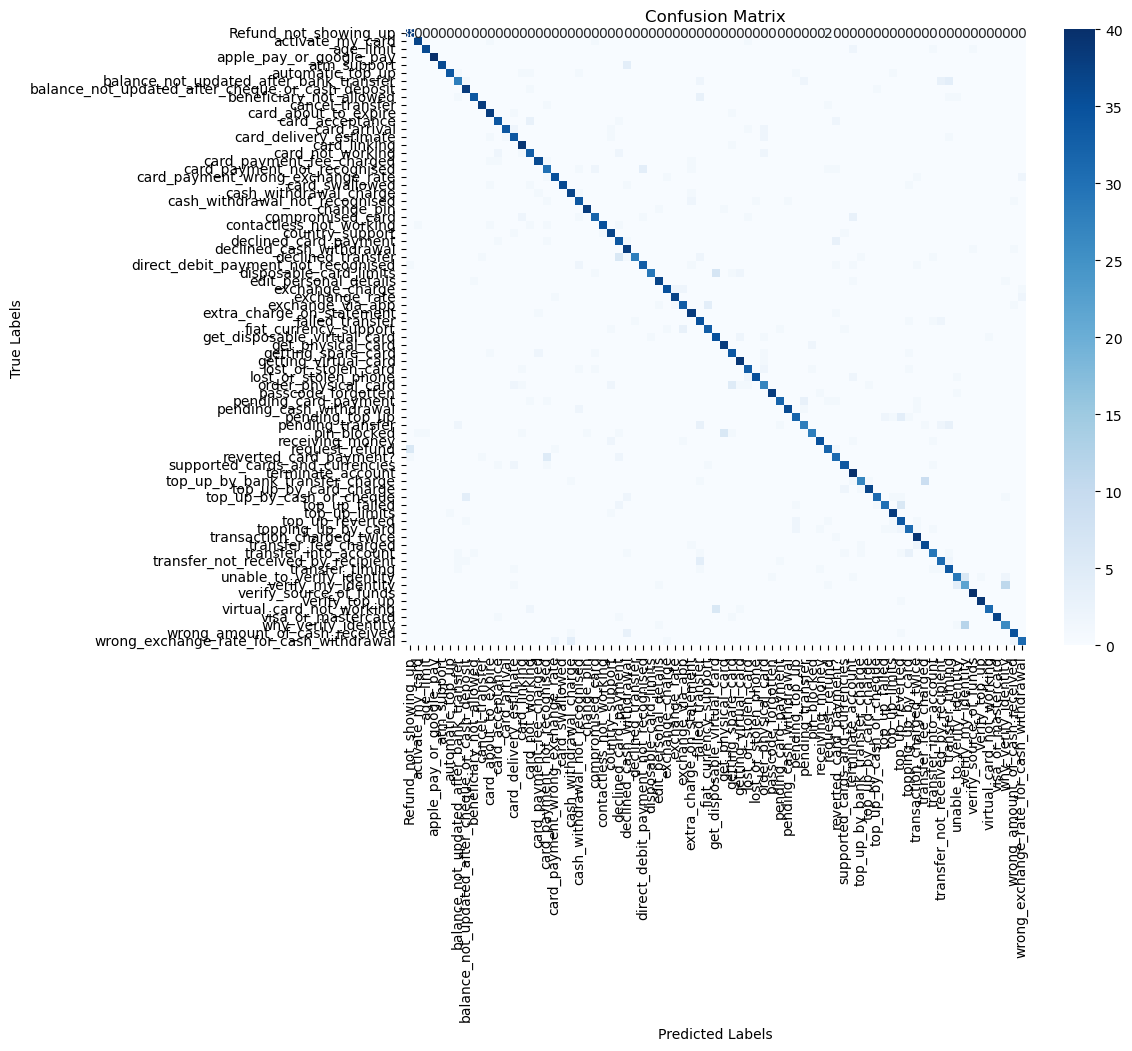

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

y_true = []
y_pred = []
with open("test_fasttext.txt", "r") as test_file:
    for line in test_file:
        label, text = line.split(" ", 1)  
        true_label = label.replace("__label__", "")
        y_true.append(true_label)

        predicted_label = trained_model.predict(text.strip())[0][0].replace("__label__", "")
        y_pred.append(predicted_label)
labels = sorted(set(y_true + y_pred))  

plot_confusion_matrix(y_true, y_pred, labels)
